# Example 1: TICA Lightcurves of WASP-62 (Sector 31)

In this notebook, we will use a simple aperture photometry to extract the lightcurve of WASP-31 as observed by TESS in Sector 31.

The star was observed by TESS on its Camera 4, CCD 1 in Sector 31 (useful in finding reference star). The TICA data was downloaded from [TESSCut](https://mast.stsci.edu/tesscut/).

In the notebook, we will follow the following steps:

1. Background Correction
2. Simple aperture photometry

And we will see if we are able to retrieve something similar to that found by SPOC pipeline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.table import Table
from astropy.stats import SigmaClip, mad_std

In [2]:
# Loading the PDCSAP Data
tim_pdc, fl_pdc, fle_pdc = np.loadtxt('Data/WASP-62_PDCSAP.dat', usecols=(0,1,2), unpack=True)

# TICA data
hdul = fits.open('Data/tica-s0031-4-1_wasp62_10x15_astrocut.fits')
tab1 = Table.read(hdul[1])

Let's first plot how PDC-SAP data looks like,

MAD of the lightcurve is: 1048.4222 ppm


Text(0.5, 1.0, 'PDC-SAP lightcurve of WASP-62 (Sector 31)')

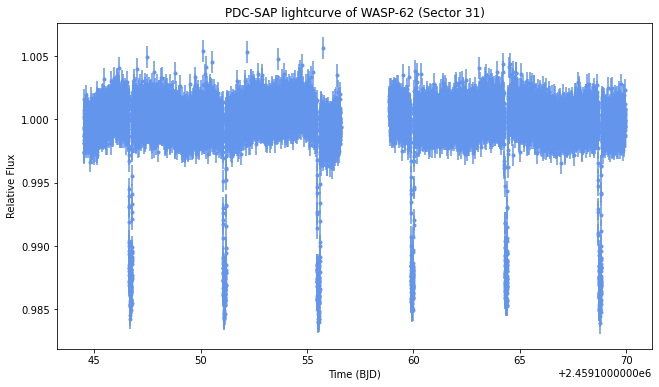

In [3]:
print('MAD of the lightcurve is: {:.4f} ppm'.format(mad_std(fl_pdc)*1e6))

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim_pdc, fl_pdc, yerr=fle_pdc, fmt='.', c='cornflowerblue')
plt.xlabel('Time (BJD)')
plt.ylabel('Relative Flux')
plt.title('PDC-SAP lightcurve of WASP-62 (Sector 31)')

And the cadence of the data (well, it's 2 min, I know but let's still check...)

In [4]:
print('Cadence of the data: ~ {:.1f} min'.format(np.median(np.diff(tim_pdc))*24*60))

Cadence of the data: ~ 2.0 min


Now, digging into TICA,

In [5]:
tab1.colnames

['TIME',
 'CADENCENO',
 'RAW_CNTS',
 'FLUX',
 'FLUX_ERR',
 'FLUX_BKG',
 'FLUX_BKG_ERR',
 'QUALITY',
 'POS_CORR1',
 'POS_CORR2',
 'FFI_FILE']

Okay, so, it has times and flux. But I believe the `FLUX_ERR` is empty -- they do not perform error propagation as this is supposed to be a "quick-look" data. The same is true for `FLUX_BKG`, `FLUX_BKG_ERR` and `QUALITY`. We show this below:

In [6]:
print(np.where(tab1['FLUX_ERR'] != 0.))
print(np.where(tab1['FLUX_BKG'] != 0.))
print(np.where(tab1['FLUX_BKG_ERR'] != 0.))
print(np.where(tab1['QUALITY'] != 0.))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64),)


See?! All of those arrays are populated with zeros. Let's see, if `POS_CORR` and `POS_CORR` has something useful in it or not.

In [7]:
print(np.where(tab1['POS_CORR1'] != 0.))
print(np.where(tab1['POS_CORR2'] != 0.))

(array([], dtype=int64),)
(array([], dtype=int64),)


Well, even those are filled with zeros. Nevermind, we will determine the positions from the center of mass of the aperture later on.

The good news here is that the `TIME` and `FLUX` fields are not all zeros -- they do have some useful data. The `TIME` column is simply times of each exposure. However, `FLUX` array is somewhat similar to a more popular TESS TPF time-stams, i.e., they are detector (cut) image at given time. And the full array is time-series.

In [8]:
tims, flxs = tab1['TIME'], tab1['FLUX']
print(tims.shape)
print(flxs.shape)

(3459,)
(3459, 15, 10)


Okay, so the flux array is 2d time-series of detector image. Let's see how one of the arbitrary time-stamp looks like.

Text(0.5, 1.0, 'Timestamp at BJD = 2161.0732')

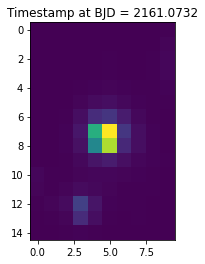

In [9]:
nint = np.random.randint(0,3460)
im = plt.imshow(flxs[nint,:,:])
plt.title('Timestamp at BJD = {:.4f}'.format(tims[nint]))

Let's see the median image,

Text(0.5, 1.0, 'Median Image')

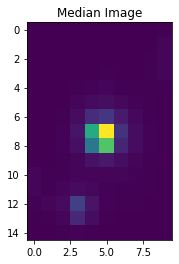

In [10]:
med_img = np.median(flxs, axis=0)

plt.imshow(med_img)
plt.title('Median Image')

Not so different! We will use this image to generate the aperture. We will do so by simply selecting ~10 brightest pixels from this image, but we need to be careful in not selecting the pixels on the bottom-right of the image.

Text(0.5, 1.0, 'Background Mask')

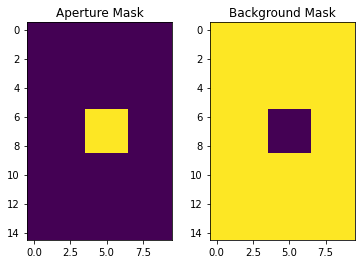

In [11]:
med_img_flat = med_img.flatten()
med_img_sorted = np.sort(med_img_flat)

ap_pix = 11
ap_mask = np.zeros(med_img.shape)
bkg_mask = np.ones(med_img.shape)
for i in range(ap_pix):
    ind = np.where(med_img == med_img_sorted[-1-i])
    # To prevent aperture being far from the center
    if (ind[0][0] > 10) or (ind[0][0] < 2):
        continue
    else:
        ap_mask[ind[0][0], ind[1][0]] = 1.
        bkg_mask[ind[0][0], ind[1][0]] = 0.

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(ap_mask)
axs[0].set_title('Aperture Mask')

axs[1].imshow(bkg_mask)
axs[1].set_title('Background Mask')

This looks reasonable! Now, we will perform background subtraction _and_ aperture photometry simultaneously.

In [12]:
xs = np.arange(ap_mask.shape[1])
ys = np.arange(ap_mask.shape[0])

lc1 = np.zeros(len(tims))
xpos, ypos = np.zeros(len(tims)), np.zeros(len(tims))
for i in range(len(tims)):
    # Background subtraction
    tstamp2 = flxs[i,:,:] - np.median(flxs[i,:,:]*bkg_mask, axis=(0,1))
    lc1[i] = np.nansum(tstamp2*ap_mask, axis=(0,1))
    # centroids
    xpos[i] = np.sum(xs*np.sum(tstamp2, axis=0))/np.sum(tstamp2, axis=(0,1))
    ypos[i] = np.sum(ys*np.sum(tstamp2, axis=1))/np.sum(tstamp2, axis=(0,1))

MAD of the lightcurve is: 2812.4767 ppm


Text(0, 0.5, 'SAP Flux')

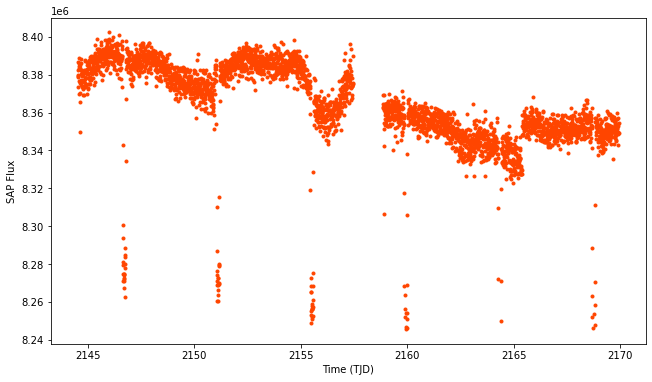

In [13]:
sc = SigmaClip(sigma_upper=5, sigma_lower=5, stdfunc=mad_std, maxiters=None)
msk1 = sc(lc1).mask

print('MAD of the lightcurve is: {:.4f} ppm'.format(mad_std(lc1[~msk1]/np.median(lc1[~msk1]))*1e6))

# Let's see how it looks (please be good)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tims[~msk1], lc1[~msk1], fmt='.', c='orangered')
plt.xlabel('Time (TJD)')
plt.ylabel('SAP Flux')

I'd say, it's not that bad! Looks sort of similar to the PDC-SAP curve. At least we can see the transit. The MAD value is much higher than that of the PDC-SAP curve, but that was sort of expected.

And how do the centroids look like?

Text(0, 0.5, 'Y positions')

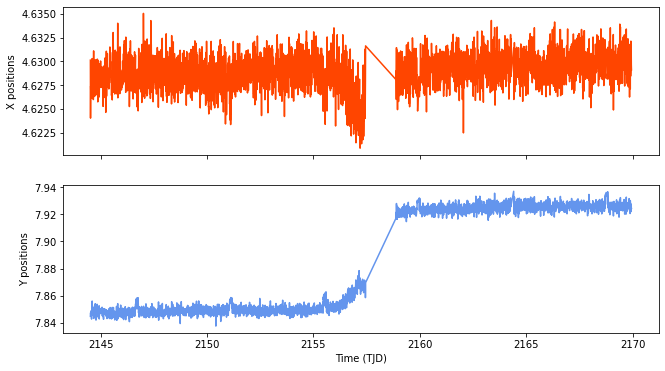

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16/1.5, 9/1.5), sharex=True)

axs[0].plot(tims[~msk1], xpos[~msk1], c='orangered')
axs[0].set_ylabel('X positions')

axs[1].plot(tims[~msk1], ypos[~msk1], c='cornflowerblue')
axs[1].set_xlabel('Time (TJD)')
axs[1].set_ylabel('Y positions')

Ohhh... I see. So, the variations in flux at the end of 1st orbit is because of shift in x- and y-centroids. So, potentially, if we were to fit this lightcurve, x- and y-centroids can be used as linear regressors in the lightcurve fitting.

In [15]:
print('Cadence of the data: ~ {:.1f} min'.format(np.median(np.diff(tims))*24*60))

Cadence of the data: ~ 10.0 min


That is why the data looks not as "dense" as PDC-SAP data.